# Multi-item EOQ Model

## Import Libraries

In [1]:
# import the nonlinear programming solver
import sys, os
import numpy as np
import pandas as pd

if 'google.colab' in sys.modules:
    %pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'
    solver = "ipopt"
else:
    solver = "mosek_direct"

import pyomo.kernel as pmo
SOLVER = pmo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

## Data Preprocessing

In [3]:
# set a seed if we want to check for correctness
np.random.seed(1)

n = 30
B= 100000
df = pd.DataFrame()
df["h"] = np.random.uniform(0.5, 2.0, n)
df["c"] = np.random.randint(300, 500, n)
df["d"] = np.random.randint(100, 5000, n)
df["b"] = np.random.uniform(10, 50,n)
df.set_index(pd.Series(f"product {i:03d}" for i in range(n)), inplace=True)

display(df)

,h,c,d,b
product 000,1.125533,330,3147,46.136077
product 001,1.580487,371,1250,15.498988
product 002,0.500172,431,1403,15.571054
product 003,0.953499,498,3553,42.295652
product 004,0.720134,449,3528,25.907073
product 005,0.638508,349,255,16.614168
product 006,0.779390,357,4509,47.100343
product 007,1.018341,303,2743,23.910634
product 008,1.095151,496,3338,40.032484
product 009,1.308225,324,748,39.039919


## Construct the Model

In [4]:
def eoq(df, B):
    m = pmo.block()

    m.b = pmo.parameter(B)

    m.I = df.index

    # variable dictionaries
    m.x = pmo.variable_dict()
    for i in m.I:
        m.x[i] = pmo.variable(lb=0)

    m.y = pmo.variable_dict()
    for i in m.I:
        m.y[i] = pmo.variable(lb=0)

    # constraints
    m.q = pmo.block_dict()
    for i in m.I:
        m.q[i] = pmo.conic.rotated_quadratic.as_domain(m.x[i], m.y[i], [np.sqrt(2)])

    m.b_cap = pmo.constraint(sum(df.loc[i, "b"] * m.x[i] for i in m.I) <= m.b)

    # objective
    m.eoq = pmo.objective(
        sum(
            df.loc[i, "h"] * m.x[i] / (2 * df.loc[i, "d"]) + df.loc[i, "c"] * m.y[i]
            for i in m.I
        )
    )

    return m


## Solve the Model

In [5]:
def solve_model(model):
    SOLVER.solve(model)

In [6]:
model = eoq(df, B)
solve_model(model)

## Result Visualization

In [7]:
def eoq_display_results(df, m):
    print(f"The optimal EOQ cost is {m.eoq().round(2)}. ")
    
    results = pd.DataFrame(
        [[i, m.x[i]()] for i in m.I],
        columns=["product", "EOQ"],
    ).round(2)
    results.set_index("product", inplace=True)

    display(results)
    results.plot(
        y=["EOQ"],
        kind="bar",
        subplots=True,
        layout=(2, 1),
        figsize=(10, 6),
    )


The optimal EOQ cost is 107.37. 


,EOQ
product,
product 000,82.58
product 001,148.47
product 002,161.86
product 003,105.99
product 004,128.54
product 005,136.92
product 006,85.09
product 007,109.71
product 008,108.67


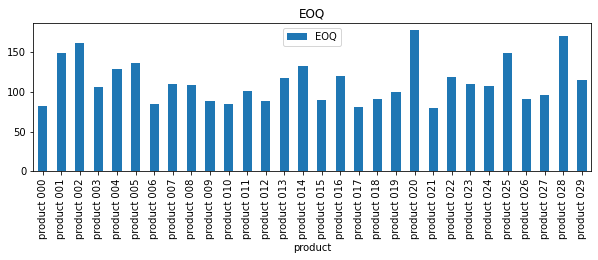

In [8]:
eoq_display_results(df, model)